In [1]:
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import utils

In [2]:
rotations = np.array([(np.pi/2 + n*np.pi/8)%(2*np.pi) for n in range(16)])
cardinals_map = dict(zip(utils.CARDINALS, rotations))

In [3]:
class LearningRateLogger(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        current_decayed_lr = self.model.optimizer._decayed_lr(tf.float32).numpy()
        print(f"Current Learning Rate =  {current_decayed_lr}")

In [4]:
df1 = pd.read_csv("weatherAUS.csv.zip")
df1 = utils.process_data(df1, cardinals_map)
df2 = pd.read_csv("weatherAUS_second_source.csv.zip")  # from https://rdrr.io/cran/rattle.data/man/weatherAUS.html
df2 = utils.process_data(df2, cardinals_map)
df = pd.concat([df1, df2])
del df1; del df2; gc.collect()
df.drop_duplicates(subset=["Date", "Location"], keep="first", inplace=True)
df.sort_values(by=["Date", "Location"], inplace=True, ignore_index=True)
df.drop(columns=["Date", "RainToday", "Cloud9am", "Cloud3pm"], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["RainTomorrow"]), df["RainTomorrow"], test_size=0.25, shuffle=False
)

del df; gc.collect()

0

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154177 entries, 0 to 154176
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Location            154177 non-null  object 
 1   MinTemp             153453 non-null  float64
 2   MaxTemp             153801 non-null  float64
 3   Rainfall            152635 non-null  float64
 4   Evaporation         85394 non-null   float64
 5   Sunshine            77552 non-null   float64
 6   WindGustSpeed       144092 non-null  float64
 7   WindSpeed9am        152587 non-null  float64
 8   WindSpeed3pm        150865 non-null  float64
 9   Humidity9am         152289 non-null  float64
 10  Humidity3pm         149801 non-null  float64
 11  Pressure9am         138690 non-null  float64
 12  Pressure3pm         138726 non-null  float64
 13  Temp9am             153206 non-null  float64
 14  Temp3pm             150726 non-null  float64
 15  Month_x_comp        154177 non-nul

In [6]:
np.log10(X_train["Rainfall"] + 1).describe()

count    152635.000000
mean          0.206855
std           0.387853
min           0.000000
25%           0.000000
50%           0.000000
75%           0.204120
max           2.570543
Name: Rainfall, dtype: float64

In [7]:
sunshine_train_pred, sunshine_test_pred = utils.generate_nan_prediction(X_train, X_test, "Sunshine")
X_train["Sunshine"] = X_train["Sunshine"].fillna(sunshine_train_pred.clip(0, 24))
X_test["Sunshine"] = X_test["Sunshine"].fillna(sunshine_test_pred.clip(0, 24))

evap_train_pred, evap_test_pred = utils.generate_nan_prediction(X_train, X_test, "Evaporation")
X_train["Evaporation"] = X_train["Evaporation"].fillna(evap_train_pred)
X_test["Evaporation"] = X_test["Evaporation"].fillna(evap_test_pred)

# cloud9am_train_pred, cloud9am_test_pred = utils.generate_nan_prediction(X_train, X_test, "Cloud9am", n_samples=365)
# X_train["Cloud9am"] = X_train["Cloud9am"].fillna(cloud9am_train_pred.clip(0, 9))
# X_test["Cloud9am"] = X_test["Cloud9am"].fillna(cloud9am_test_pred.clip(0, 9))

# cloud3pm_train_pred, cloud3pm_test_pred = utils.generate_nan_prediction(X_train, X_test, "Cloud3pm", n_samples=365)
# X_train["Cloud3pm"] = X_train["Cloud3pm"].fillna(cloud9am_train_pred.clip(0, 9))
# X_test["Cloud3pm"] = X_test["Cloud3pm"].fillna(cloud9am_test_pred.clip(0, 9))

Model:
Sunshine = 0.273LAT + 0.007LNG + 1.689Month_x + 1.361Month_y + -0.164Temp9am + 18.026
Model:
Evaporation = 0.137LAT + 0.006LNG + 1.746Month_x + 1.089Month_y + 0.069Temp9am + 7.334


In [8]:
X_train.update(X_train.groupby("Location").ffill())
X_test.update(X_test.groupby("Location").ffill())

for col in X_train:
    X_train[col] = X_train[col].fillna(utils.DEFAULT_VALS.get(col, np.nan))

for col in X_test:
    X_test[col] = X_test[col].fillna(utils.DEFAULT_VALS.get(col, np.nan))

cols_to_lag = ["Temp3pm", "Humidity3pm", "Pressure3pm",
               "WindSpeed3pm", "Evaporation", "Sunshine"]

X_train = utils.feature_transformer(X_train)
X_test = utils.feature_transformer(X_test)

lags = [1, 2]

for lag in lags:
    shifted = X_train.groupby("Location")[cols_to_lag].shift(lag)
    shifted.columns = shifted.columns.map(lambda c: f"{c}_LAG{lag}")
    X_train = X_train.merge(shifted, left_index=True, right_index=True)

    shifted = X_test.groupby("Location")[cols_to_lag].shift(lag)
    shifted.columns = shifted.columns.map(lambda c: f"{c}_LAG{lag}")
    X_test = X_test.merge(shifted, left_index=True, right_index=True)


for col in cols_to_lag:
    for lag in lags:
        X_train[f"{col}_LAG{lag}"] = X_train[f"{col}_LAG{lag}"].fillna(utils.DEFAULT_VALS.get(col, np.nan))
        X_test[f"{col}_LAG{lag}"] = X_test[f"{col}_LAG{lag}"].fillna(utils.DEFAULT_VALS.get(col, np.nan))

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False
)

y_train.drop(y_train.head(1).index, inplace=True)
y_valid.drop(y_valid.head(1).index, inplace=True)
y_test.drop(y_test.head(1).index, inplace=True)

In [10]:
X_train = utils.scaler(X_train)
X_valid = utils.scaler(X_valid)
X_test = utils.scaler(X_test)
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(123340, 54) (30835, 54) (51392, 54)
(123340,) (30835,) (51392,)


In [11]:
X_train.info(show_counts=True)
X_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123340 entries, 1 to 123340
Data columns (total 54 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   MinTemp             123340 non-null  float64
 1   MaxTemp             123340 non-null  float64
 2   Rainfall            123340 non-null  float64
 3   Evaporation         123340 non-null  float64
 4   Sunshine            123340 non-null  float64
 5   WindGustSpeed       123340 non-null  float64
 6   WindSpeed9am        123340 non-null  float64
 7   WindSpeed3pm        123340 non-null  float64
 8   Humidity9am         123340 non-null  float64
 9   Humidity3pm         123340 non-null  float64
 10  Pressure9am         123340 non-null  float64
 11  Pressure3pm         123340 non-null  float64
 12  Temp9am             123340 non-null  float64
 13  Temp3pm             123340 non-null  float64
 14  Month_x_comp        123340 non-null  float64
 15  Month_y_comp        123340 non-nul

MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
1  0.705444  0.703281  0.704340     0.697246  0.704178       0.705997   
2  0.530844 -0.802550  0.574586     1.042059 -0.975483       1.140802   
3  0.367415 -1.427027  1.493066     1.199539  0.679152       0.082868   
4 -1.149572 -0.999222 -0.427295     0.219724  0.934903      -0.076476   
5 -1.194155 -0.733313 -0.534426     0.328039  0.124155      -0.333867   

   WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  \
1     -0.702142     -0.703789     0.706274     0.705681  ...   
2      0.572393     -1.129007     0.703432     1.138563  ...   
3      1.494428      0.938023    -1.145635     0.463231  ...   
4      0.597717      1.074422    -0.464451     0.075441  ...   
5      0.537185      0.536477    -0.215127     0.520975  ...   

   WindSpeed3pm_LAG1  Evaporation_LAG1  Sunshine_LAG1  Temp3pm_LAG2  \
1           0.706108          0.704178       0.705523      0.000000   
2           0.259323          0.777030       0.885425      1.149172   
3          -1.131643          0.967287      -0.367012      1.193320   
4           1.170889          1.108371       0.838814     -0.646594   
5           1.257987          0.475443       0.984281     -1.640078   

   Humidity3pm_LAG2  Pressure3pm_LAG2  WindSpeed3pm_LAG2  Evaporation_LAG2  \
1          0.000000          0.000000           0.000000          0.000000   
2         -1.154056          0.000000           1.152704          1.148848   
3         -0.634979         -1.495468           0.542621          1.065970   
4          1.052453         -1.237313          -1.150401          1.168764   
5          0.277539         -1.033691           1.370657          1.250132   

   Sunshine_LAG2  Location  
1       0.000000  Canberra  
2       1.151535  Canberra  
3       1.179425  Canberra  
4      -0.133383  Canberra  
5       1.009865  Canberra  

[5 rows x 54 columns]

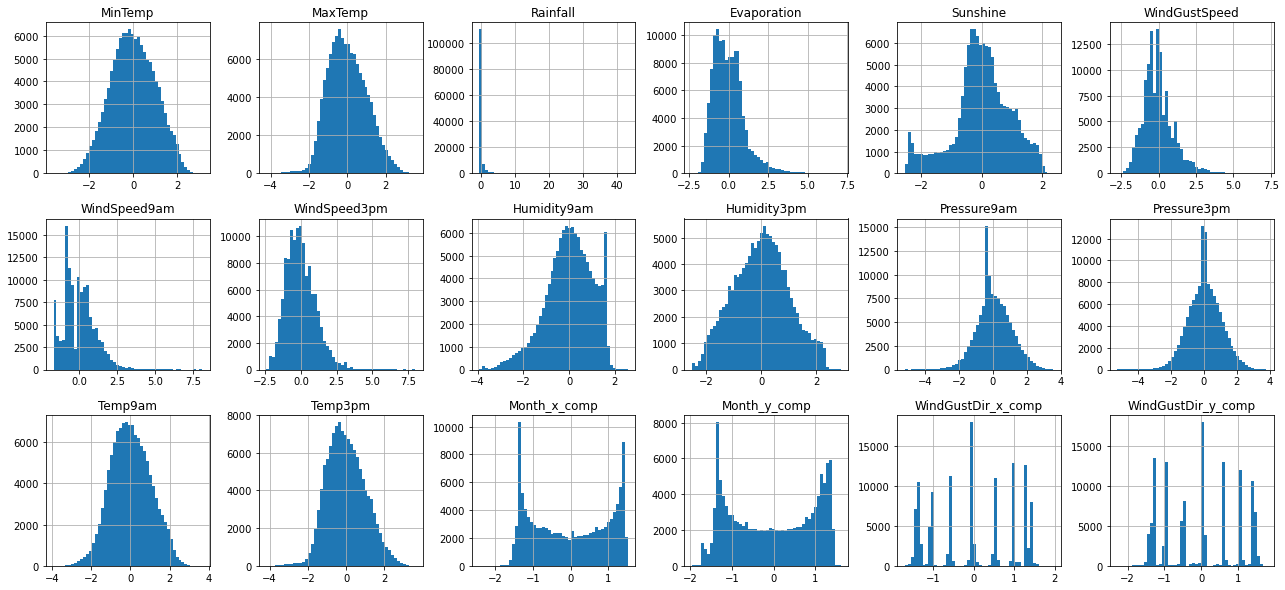

In [12]:
X_train[X_train.columns[:18]].hist(figsize=(22, 10), bins=50, layout=(3, 6));

In [13]:
def create_model(input_dim):
    model = keras.Sequential(
        [
            keras.layers.Dense(128, input_dim=input_dim, activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dense(32, activation="relu"),
            keras.layers.Dense(16, activation="relu"),
            keras.layers.Dense(8, activation="relu"),
            keras.layers.Dense(1, activation="sigmoid")
        ]
    )
    
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    0.0015, decay_steps=5000, decay_rate=0.95, staircase=True
)

    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=["accuracy"]
    )
    return model

In [14]:
model = create_model(len(X_train.columns) - 1)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               6912      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4

In [15]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("deep_nn.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=25, restore_best_weights=True)

history = model.fit(
    X_train.drop(columns=["Location"]),
    y_train,
    validation_data=(X_valid.drop(columns=["Location"]), y_valid),
    epochs=150,
    batch_size=64,
    callbacks=[early_stopping_cb, checkpoint_cb, LearningRateLogger()]
)

Epoch 1/150
Current Learning Rate =  0.001500000013038516
1928/1928 [==============================] - 9s 4ms/step - loss: 0.4176 - accuracy: 0.8159 - val_loss: 0.4023 - val_accuracy: 0.8440
Epoch 2/150
Current Learning Rate =  0.001500000013038516
1928/1928 [==============================] - 6s 3ms/step - loss: 0.3612 - accuracy: 0.8488 - val_loss: 0.3818 - val_accuracy: 0.8488
Epoch 3/150
Current Learning Rate =  0.001500000013038516
1928/1928 [==============================] - 6s 3ms/step - loss: 0.3517 - accuracy: 0.8529 - val_loss: 0.3738 - val_accuracy: 0.8440
Epoch 4/150
Current Learning Rate =  0.0014250000240281224
1928/1928 [==============================] - 6s 3ms/step - loss: 0.3476 - accuracy: 0.8540 - val_loss: 0.3677 - val_accuracy: 0.8477
Epoch 5/150
Current Learning Rate =  0.0014250000240281224
1928/1928 [==============================] - 6s 3ms/step - loss: 0.3445 - accuracy: 0.8546 - val_loss: 0.3550 - val_accuracy: 0.8486
Epoch 6/150
Current Learning Rate =  0.0014

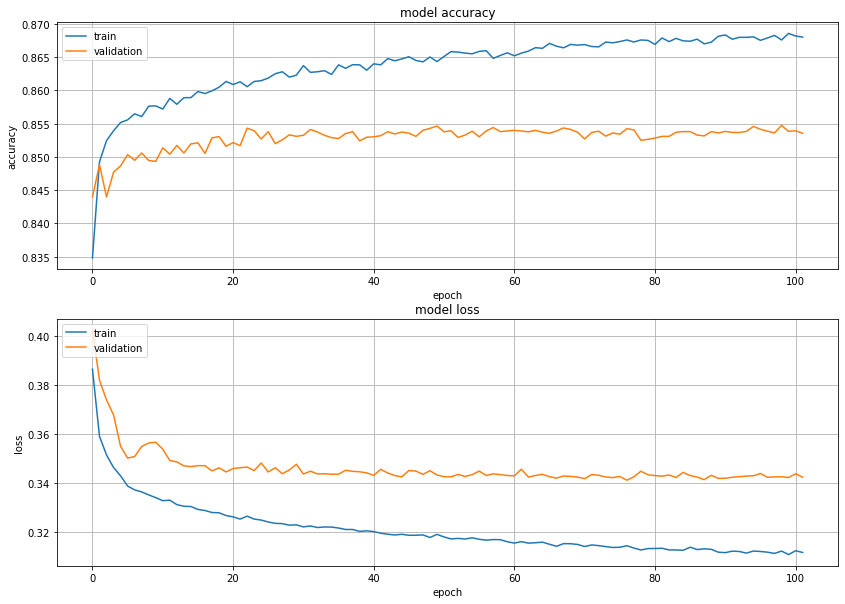

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')
ax1.grid()

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper left')
ax2.grid()

In [17]:
y_prob = model.predict(X_test.drop(columns=["Location"]))

/Users/ajaypethani/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


              precision    recall  f1-score   support

           0       0.90      0.92      0.91     40924
           1       0.67      0.62      0.64     10468

    accuracy                           0.86     51392
   macro avg       0.79      0.77      0.78     51392
weighted avg       0.86      0.86      0.86     51392



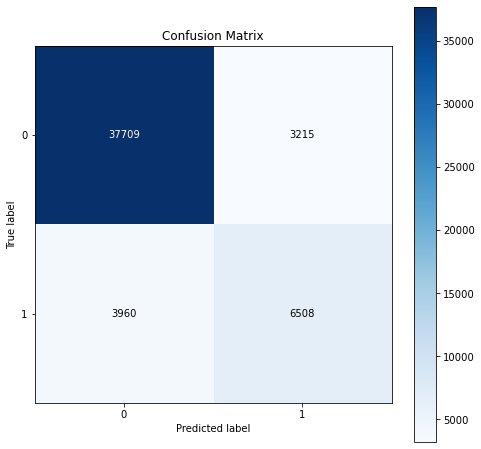

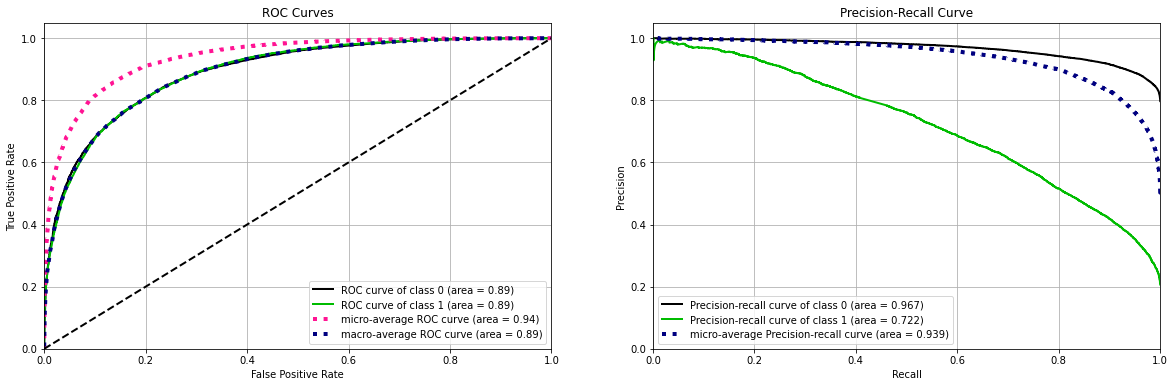

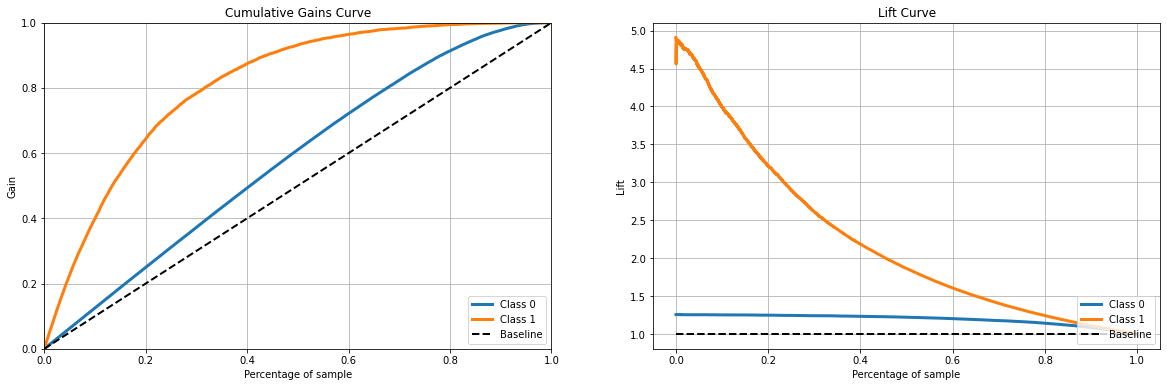

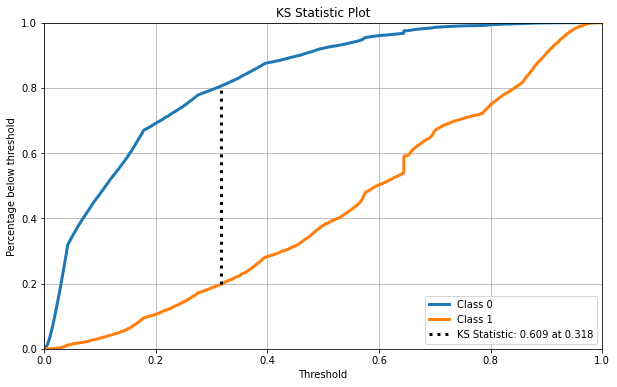

In [18]:
utils.evaluate_binary_clf(
    X_test.drop(columns=["Location"]),
    y_test,
    model=model,
    y_pred=(y_prob > 0.5).astype("int32").flatten(),
    y_prob=np.hstack((1 - y_prob, y_prob))
)

# Evaluating on train set to check for overfitting

/Users/ajaypethani/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


              precision    recall  f1-score   support

           0       0.90      0.94      0.92     95954
           1       0.75      0.65      0.69     27386

    accuracy                           0.87    123340
   macro avg       0.82      0.79      0.81    123340
weighted avg       0.87      0.87      0.87    123340



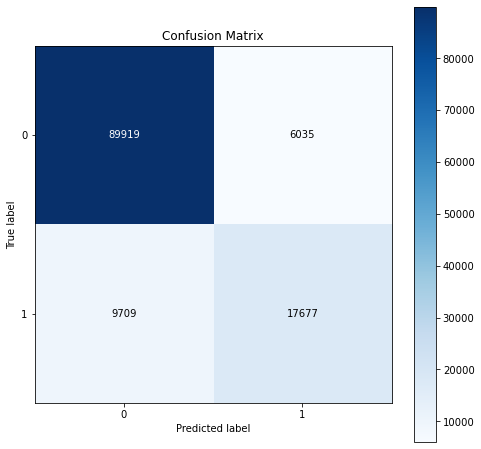

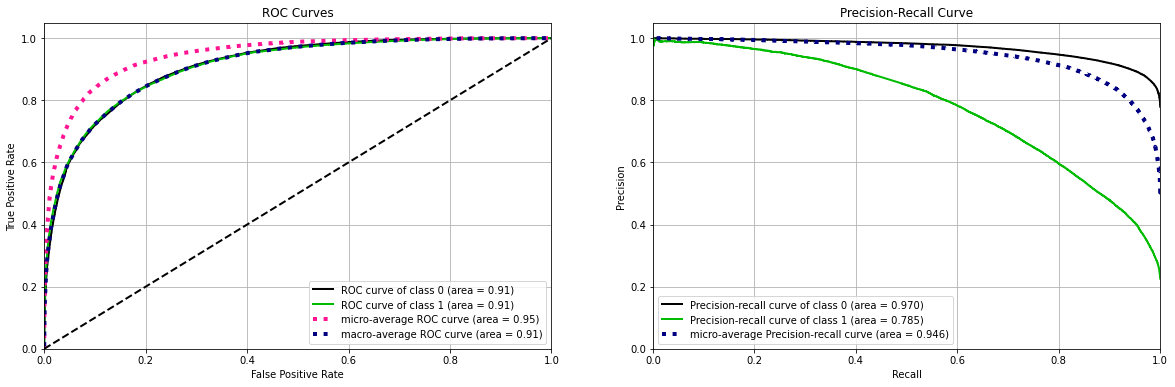

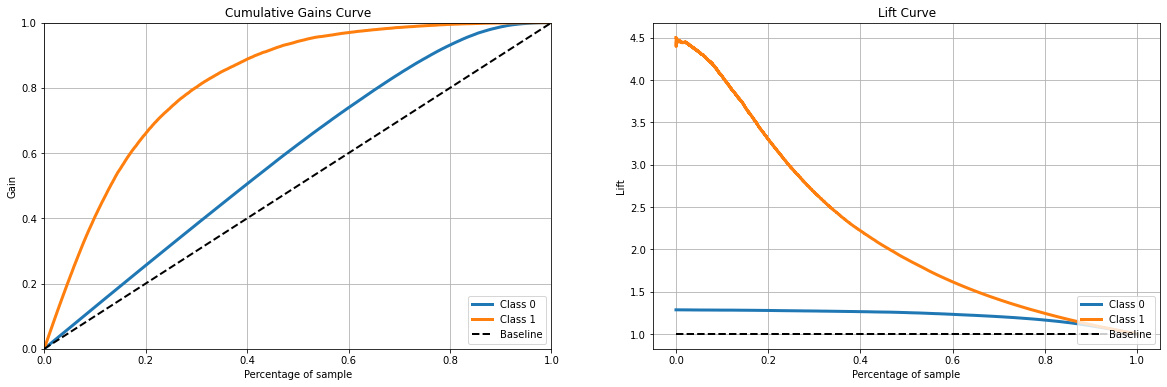

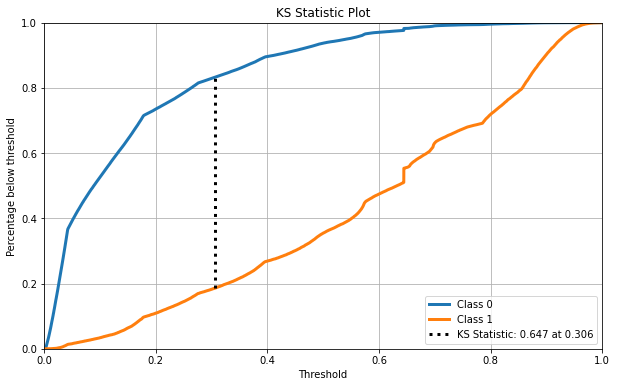

In [19]:
y_prob_train = model.predict(X_train.drop(columns=["Location"]))

utils.evaluate_binary_clf(
    X_train.drop(columns=["Location"]),
    y_train,
    model=model,
    y_pred=(y_prob_train > 0.5).astype("int32").flatten(),
    y_prob=np.hstack((1 - y_prob_train, y_prob_train))
)

In [20]:
X_test["confidence"] = np.hstack((1 - y_prob, y_prob)).max(1)
X_test["pred"] = (y_prob > 0.5).astype("int32").flatten()
X_test["actual"] = y_test
X_test["correct"] = (X_test["pred"] == X_test["actual"])

In [21]:
X_test.groupby("Location")['confidence'].median().sort_values().plot.bar(backend='plotly')

In [22]:
X_test.groupby("Location")["correct"].apply(lambda s: s.sum()/len(s)).sort_values().plot.bar(backend='plotly')

In [23]:
(X_test
 .assign(correct_adj=X_test["correct"]*X_test["confidence"])
 .groupby("Location")["correct_adj"]
 .median()
 .sort_values().plot.bar(backend='plotly'))

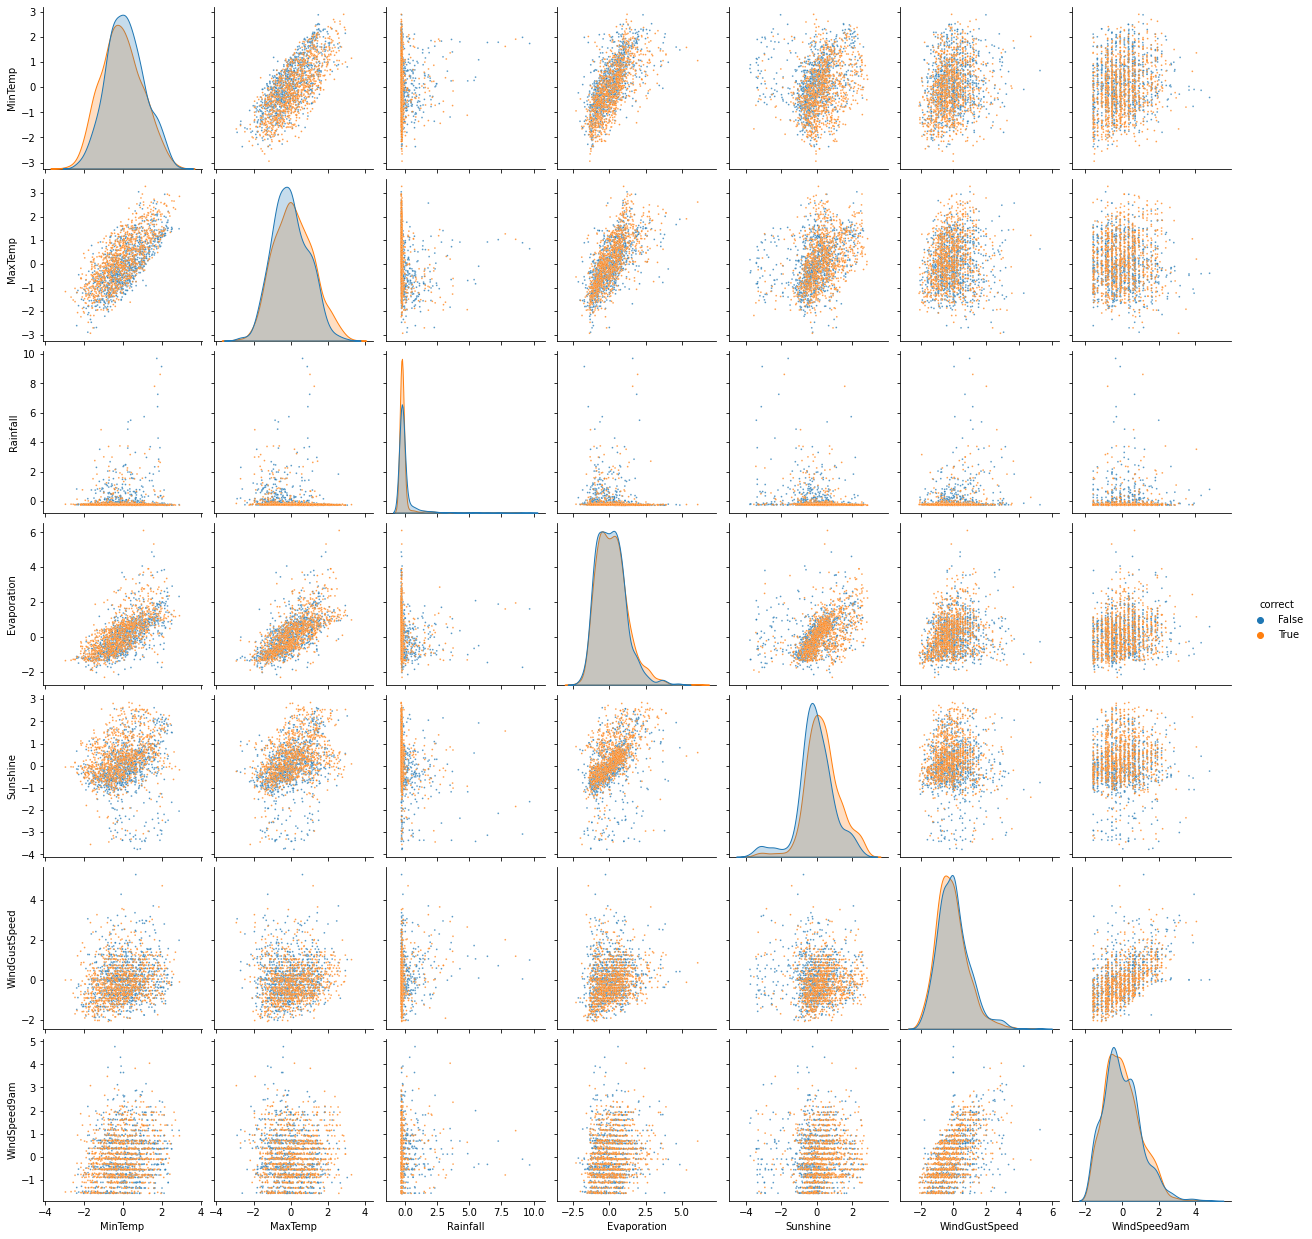

In [24]:
sns.pairplot(
    (X_test[(X_test["confidence"] > 0.8)][[col for col in X_test][:7] + ["correct"]]
     .groupby('correct')
     .apply(lambda x: x.sample(n=1000))
     .reset_index(drop=True)),
    hue="correct",
    plot_kws={"alpha": 0.75, "s": 3}
)

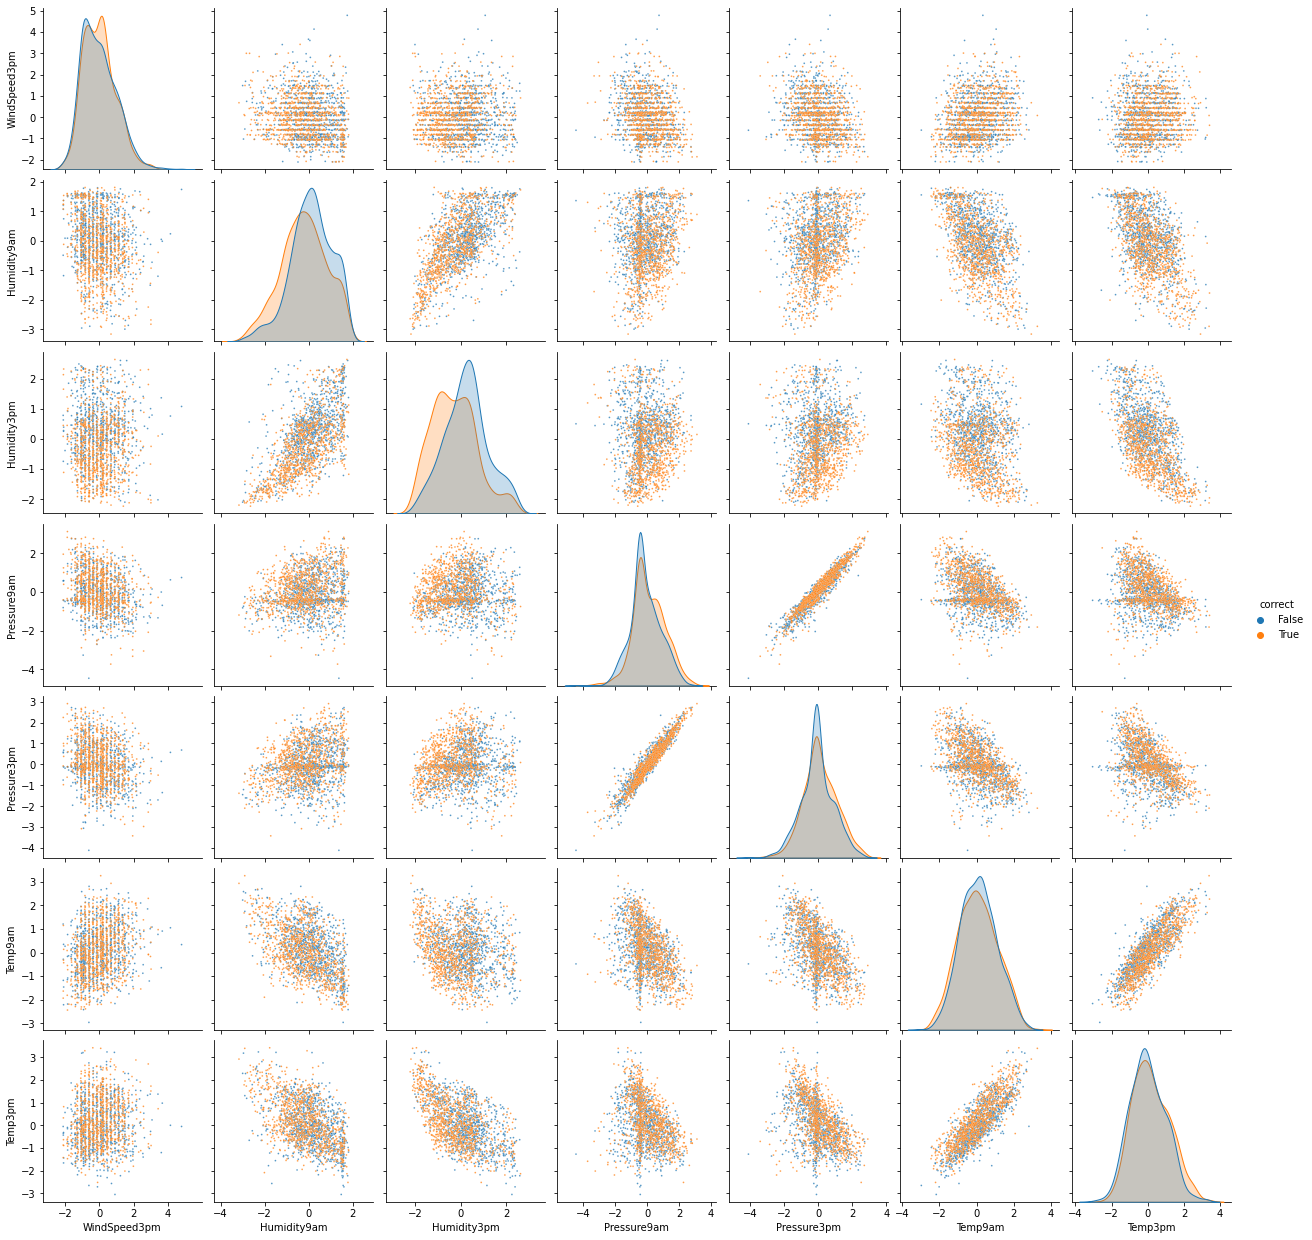

In [25]:
sns.pairplot(
    (X_test[(X_test["confidence"] > 0.8)][[col for col in X_test][7:14] + ["correct"]]
     .groupby('correct')
     .apply(lambda x: x.sample(n=1000))
     .reset_index(drop=True)),
    hue="correct",
    plot_kws={"alpha": 0.75, "s": 3}
)

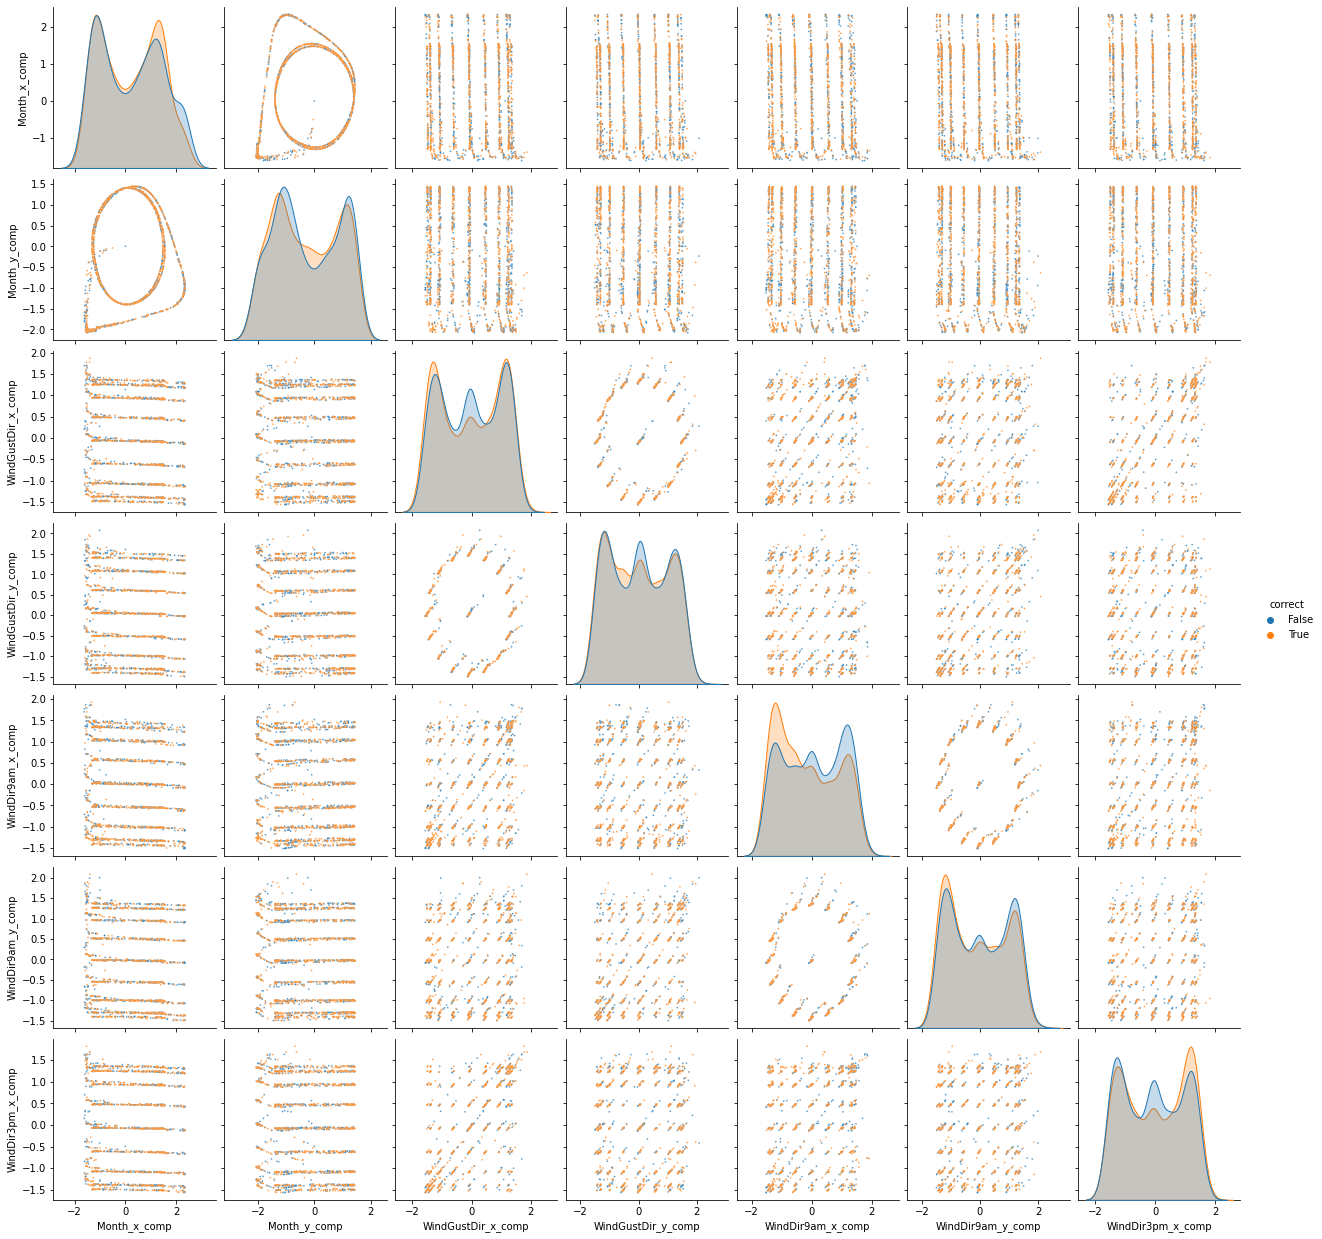

In [26]:
sns.pairplot(
    (X_test[(X_test["confidence"] > 0.8)][[col for col in X_test][14:21] + ["correct"]]
     .groupby('correct')
     .apply(lambda x: x.sample(n=1000))
     .reset_index(drop=True)),
    hue="correct",
    plot_kws={"alpha": 0.75, "s": 3}
)